In [1]:
import numpy as np
import pandas as pd
import requests as req
import emcee
from matplotlib import pyplot as plt
import corner
from scipy.optimize import minimize
%matplotlib inline

# Introduction

The stated purpose of this notebook is to explore some cryptocurrency data. Yahoo! doesn't seem to allow programmatic access to its financial data, including crypto data. I felt that scraping data is outside of the scope of this project and so I opted to use a [different API](https://cryptocompare.com) which provides similar data, instead.

We begin by exploring the API a little bit. We then request extensive historical price data on several cryptocurrencies. After briefly analyzing some of the summary statistics of the data, we begin to work on a predictive model of asset returns, concluding with an application to portfolio choice.

# Exploration

In [2]:
endpoint = "https://min-api.cryptocompare.com/data/"
api_key = "f42555b48bbf03e7f64fdbfde60ebe62905fd2103ec9beada0969c3d81c749a8"

In [3]:
def req_url(meth, params):
    params["api_key"] = api_key
    
    return endpoint + meth + "?" + "&".join(["{}={}".format(k, v) for k, v in params.items()])

First, we'll request the top 100 crypto symbols by volume, so that we can request the prices of them:

In [4]:
meth = "top/totalvolfull"
params = {}
params["limit"] = 100
params["tsym"] = "USD"

ru = req_url(meth, params)
data = req.get(ru).json()['Data']
top = list(map(lambda c: c['CoinInfo']['Name'], data))
n_top = len(top)

We can only request 1 crypto symbol at a time. We'll request 3 years of data:

In [5]:
meth = "histoday"

n_top = 10
data = {}
for i in range(n_top):
    params = {}
    params["fsym"] = top[i]
    params["tsym"] = "USD"
    params["limit"] = 1 * 365
    ru = req_url(meth, params)
    data[top[i]] = req.get(ru).json()['Data']

In [6]:
times = np.asarray(list(map(lambda tp: tp['time'], data["BTC"])))[:, np.newaxis]
highs = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["high"], data[ticker])), data.keys()))).T

In [7]:
df = pd.DataFrame(np.concatenate([times, highs], axis=1))

In [8]:
df.columns = ["time"] + top[:n_top]

In [9]:
df.head()

,time,BTC,ETH,EOS,LTC,XRP,ENJ,BCH,ZEC,QTUM,NEO
0,1.520640e+09,9518.62,747.82,6.45,194.73,0.8412,0.1391,1089.16,318.14,19.86,94.48
1,1.520726e+09,9735.64,735.01,6.20,193.19,0.8301,0.1555,1157.26,318.91,19.56,92.48
2,1.520813e+09,9907.41,739.87,6.18,193.04,0.8282,0.1471,1150.22,314.25,19.39,92.58
3,1.520899e+09,9486.12,714.19,5.94,181.94,0.7991,0.1406,1099.83,302.23,23.15,88.42
4,1.520986e+09,9360.66,703.38,6.03,178.04,0.7918,0.1201,1072.38,293.33,18.65,85.67


In [10]:
# r(t) = log(x(t + 1)/x(t)) where x(t) is asset price
def returns(x):
    T = len(x)
    r = np.zeros(T - 1)
    for t in range(T - 1):
        r[t] = np.log(x[t+1]/x[t])
    
    return r

In [11]:
btc = returns(np.asarray(df['BTC']))
eth = returns(np.asarray(df['ETH']))
eos = returns(np.asarray(df['EOS']))
ltc = returns(np.asarray(df['LTC']))
xrp = returns(np.asarray(df['XRP']))
bch = returns(np.asarray(df['BCH']))

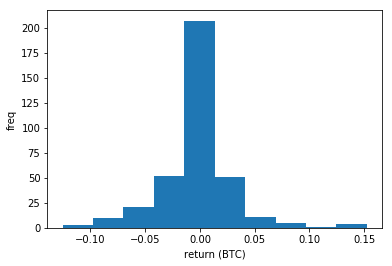

In [12]:
plt.hist(btc)
plt.xlabel("return (BTC)")
plt.ylabel("freq")
plt.show()

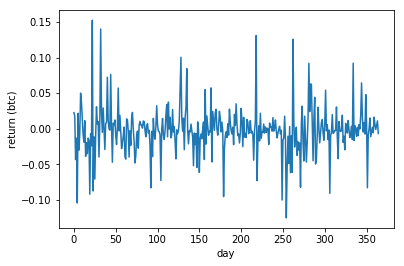

In [13]:
plt.plot(btc)
plt.xlabel("day")
plt.ylabel("return (btc)")
plt.show()

In [14]:
T = 50
data = np.concatenate((btc[:T, np.newaxis],
                       eth[:T, np.newaxis],
                       eos[:T, np.newaxis],
                       ltc[:T, np.newaxis],
                       xrp[:T, np.newaxis],
                       bch[:T, np.newaxis]), axis=1).T

We can see that the returns are highly correlated across all 6 cryptocurrencies. This greatly affects things like portfolio choice - how do you make a selection of assets in such a way that you maximize returns while minimizing risk (as measured by volatility)?

[[1.         0.62197587 0.3430359  0.56078956 0.61218694 0.55857313]
 [0.62197587 1.         0.46807746 0.81668164 0.83580443 0.74801569]
 [0.3430359  0.46807746 1.         0.48501086 0.58109916 0.40092559]
 [0.56078956 0.81668164 0.48501086 1.         0.77951151 0.68965464]
 [0.61218694 0.83580443 0.58109916 0.77951151 1.         0.6860612 ]
 [0.55857313 0.74801569 0.40092559 0.68965464 0.6860612  1.        ]]


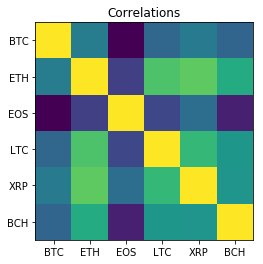

In [15]:
currencies = ['BTC', 'ETH', 'EOS', 'LTC', 'XRP', 'BCH']

cor = np.corrcoef(data)
print(cor)
plt.imshow(cor)
plt.xticks(range(len(currencies)), currencies)
plt.yticks(range(len(currencies)), currencies)
plt.title("Correlations")
plt.show()

In Gaussian process models, it's important to standardize the data because the kernels we construct are in fact assumed to have diagonally unit variance. This is less important for the GWP model, because any adjustments to the overall scale of the data can be "absorbed" into $L$. However, for consistency with our later GP model for predicting $\mathbf{r}(t)$, we'll proceed with standardization anyway:

In [16]:
normalizer = np.diag(1/np.sqrt(np.diag(np.cov(data))))
data_std = np.matmul(normalizer, data)
np.cov(data_std)

array([[1.        , 0.62197587, 0.3430359 , 0.56078956, 0.61218694,
        0.55857313],
       [0.62197587, 1.        , 0.46807746, 0.81668164, 0.83580443,
        0.74801569],
       [0.3430359 , 0.46807746, 1.        , 0.48501086, 0.58109916,
        0.40092559],
       [0.56078956, 0.81668164, 0.48501086, 1.        , 0.77951151,
        0.68965464],
       [0.61218694, 0.83580443, 0.58109916, 0.77951151, 1.        ,
        0.6860612 ],
       [0.55857313, 0.74801569, 0.40092559, 0.68965464, 0.6860612 ,
        1.        ]])

# Goal

Our goal is to build a predictive model for portfolio choice. Formally:

Let $\mathbf{r}(t) \in \mathbb{R}^n$ be the return of each of $n$ assets at time $t$, where $r_i(t) = \log{\frac{x_i(t + 1)}{x_i(t)}}$ for $i = 1, \dots, n$. Define the asset covariance matrix as in the econometrics literature as $\Sigma(t) = \mathbf{r}(t) \mathbf{r}(t)^T \in \mathbb{R}^{n \times n}$. Let our training data be $\{ \mathbf{r}(t) | t \in 1, \dots, T \}$ where $T$ is the number of training timepoints. Our goal is to define a model capable of then predicting $r(T + 1)$ and $\Sigma(T + 1)$. We can then optimize portfolio choice by maximizing the Sharpe ratio:

$$\frac{\mathbf{w}^T \mathbf{r}(T + 1)}{\sqrt{\mathbf{w}^T \Sigma(T + 1) \mathbf{w}}}$$

where $\mathbf{w} \in \mathbb{S}^{n - 1}$, i.e. $\mathbf{w}$ is a unit vector.

Note that we're being deliberately vague about how we're going to compute $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ - we'll try a number of different predictive models with the same sort of general idea.

# Choosing a model

There are several possible methods to estimate $\mathbf{r}(T + 1)$:

* Simple regression
* Autoregressive models (ARCH, GARCH, ...)
* Neural networks (RNNs in particular)
* Bayesian methods

There are also methods (apparently generally lesser-known outside of econometrics) to estimate $\Sigma(T + 1)$, including autoregressive models like MGARCH, but these frequently make problematic assumptions.

## Proposed model

I propose to use the [generalized Wishart process (GWP)](https://www.cs.cmu.edu/~andrewgw/gwp.pdf) to model $\Sigma(t)$ and a Gaussian process (GP) to model $\mathbf{r}(t)$. Together, these will produce estimates of $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ which can then be used for portfolio choice.

There are advantages to modelling the price separate from the covariance. For example, consider the Ornstein-Uhlenbeck and squared exponential kernels. The first is great for modeling more volatile data, like currency (real and crypto-). The second is used for more smooth functions. One might assume that while the actual returns follow an O-U Gaussian process, the covariance between currencies is in fact smoother and follows a SE generalized Wishart process.

In [ ]:
def ou(t1, t2, params):
    """
    Ornstein-Uhlenbeck kernel. Commonly used for financial data because
    it's not quite as smooth as the squared-exponential kernel.
    """
    tau = params[0]
    
    return SIG_VAR * np.exp(-abs(t2 - t1)/tau)

def squared_exponential(t1, t2, params):
    """
    Squared-exponential kernel.
    """
    tau = params[0]
    
    return SIG_VAR * np.exp(-((t1 - t2)/tau)**2)

def periodic(t1, t2, params):
    """
    A simple periodic kernel function.
    """
    tau = params[0]
    
    return np.exp(-2*np.sin((t1 - t2)/2)**2/tau**2)

### Covariance model

The model for $\Sigma(t)$ follows. It's a direct implementation of equations (15)-(17) and the  sampling procedure described in the GWP paper. We follow their direction and implement [elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf) for sampling the GPs which construct $\Sigma(t)$. We use the `emcee` library in Python for the Metropolis-Hasting steps (learning $L$ and $\mathbf{\theta}$). The main flow of the program is captured in `gibbs_sampler`. I opted not to wrap these methods in a class because it made Jupyter development easier. At the end of this notebook I'll describe how I created and tested the final version of this code (which is in a separate file, with tests).

In [ ]:
SIG_VAR = 0.95
KERNEL = squared_exponential
LOGTHETA_PRIOR_MEAN = 0.5
LOGTHETA_PRIOR_VAR = 2
L_PRIOR_VAR = 1
MH_THETA_SCALE = 1
MH_L_SCALE = 1e-1
KERNEL_SCALE = 1

def kidx(Nu, N, T):
    return lambda a, b, c: a * (N * T) + b * T + c

def construct_kernel(params, T, k):
    """
    Construct a GP kernel.
    
    params: The kernel parameters of dimension ν x N x h where ν is the
            d.f., N is the dimensionality of the data, and h is the number
            of parameters for the kernel function.
    T:      The number of timepoints.
    k:      The kernel function.
    
        Returns a νNT x νNT kernel matrix.
    """
    Nu, N, h = params.shape
    kernel_idx = kidx(Nu, N, T)
    
    K = np.eye(np.prod([Nu, N, T]))
    for nu in range(Nu):
        for n in range(N):
            for t1 in range(T):
                for t2 in range(T):
                    i = kernel_idx(nu, n, t1)
                    j = kernel_idx(nu, n, t2)
                    if t1 != t2:
                        K[i, j] = k(t1, t2, params[nu, n, :])
    
    return K * KERNEL_SCALE

def compute_sigma(L, u):
    """
    Compute the covariance matrix for a specific timepoint.
    
    L: The lower cholesky decomposition of the scale parameter for the Wishart
       distribution (of dimension N x N).
    u: The fitted GP function values that generate the draw from the Wishart distribution.
       Dimensionality: ν x N.
       
    Returns the N x N covariance matrix.
    """
    Nu = u.shape[0]
    Sig = np.zeros(L.shape)
    for nu in range(Nu):
        Sig += np.matmul(L, np.matmul(np.outer(u[nu, :], u[nu, :]), L.T))
    
    return Sig

def log_data_likelihood(returns, u, L, Nu):
    """
    The likelihood of the data. We sum over all possible timepoints
    $t \in [T]$, computing the probability using r(t) ~ N(0, Σ(t)).
    """
    loglik = 0
    N, T = returns.shape
    u = np.reshape(u, (Nu, N, T))
    for t in range(T):
        Siginv = np.linalg.inv(compute_sigma(L, u[:, :, t]))
        term = -0.5*np.matmul(returns[:, t].T, np.matmul(Siginv, returns[:, t]))
        loglik += term
    
    return loglik

def init_logtheta(nu, N, h=1):
    """
    Initialize the GP hyperparameters to their logs.
    
    Returns a ν x N x h matrix where each is an independent draw from
    the LogNormal prior.
    """
    return np.random.normal(size=(nu, N, h))

def init_u(T, theta):
    """
    Initialize the GP draws that will construct the covariance matrix.
    
    T:     The number of timepoints.
    theta: The kernel parameters, of dimension ν x N x h where ν is the
           d.f., N is the dimensionality of the data, and h is the number
           of parameters for the kernel function.
    
    Returns a matrix of dimension ν x N x T which is a random draw from
    the multivariate normal with kernel constructed by theta.
    """
    N, nu, _ = theta.shape
    K = construct_kernel(theta, T, KERNEL)
    draw = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
    
    return draw

def init_L(N):
    """
    Initialize the scale parameter for the Wishart distribution.
    
    Randomly generates a symmetric matrix V, then returns its lower
    Cholesky decomposition.
    """
    # X = np.random.randn(N, N)
    # V = np.matmul(X, X.T)
    # L = np.linalg.cholesky(V)
    L = np.eye(N)
    
    return L * L_PRIOR_VAR

def sample_u(f, theta, T, L, nu, returns):
    """
    Sample u (equation 15). We use
    [elliptical slice sampling](https://arxiv.org/abs/1001.0175),
    specifically a direct implementation of the algorithm in figure 2.
    """
    K = construct_kernel(theta, T, KERNEL)
    Kinv = np.linalg.inv(K)
    
    ellipse = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
    u = np.random.uniform()
    logy = log_data_likelihood(returns, f, L, nu) + np.log(u)
    angle = np.random.uniform(high=2*np.pi)
    angle_min, angle_max = angle - 2*np.pi, angle
    while True:
        fp = f*np.cos(angle) + ellipse*np.sin(angle)
        log_data_lik = log_data_likelihood(returns, fp, L, nu)
        if log_data_lik > logy:
            log_u_lik = -0.5*np.matmul(fp, np.matmul(Kinv, fp))
            return fp, log_data_lik + log_u_lik
        else:
            if angle < 0:
                angle_min = angle
            else:
                angle_max = angle
            angle = np.random.uniform(angle_min, angle_max)

def sample_logtheta(logtheta, u, T, L, nu, returns):
    """
    Sample theta (equation 16). We use standard M-H as implemented in
    emcee to directly sample the next position in the chain.
    """
    def log_logtheta_prob(logthp):
        """
        Computes log(P(u | theta) * P(theta)) directly.
        """
        logthp = np.reshape(logthp, theta.shape)
        K = construct_kernel(np.exp(logthp), T, KERNEL)
        Kinv = np.linalg.inv(K)
        log_u_prob = -0.5*np.matmul(u, np.matmul(Kinv, u))
        log_prior = np.sum(
            -0.5*((logthp - LOGTHETA_PRIOR_MEAN)**2/LOGTHETA_PRIOR_VAR)
        )
        
        return log_u_prob + log_prior
        
    dim = np.prod(logtheta.shape)
    sampler = emcee.MHSampler(np.eye(dim)*MH_THETA_SCALE, dim=dim, lnprobfn=log_logtheta_prob)
    logthetap, _, _ = sampler.run_mcmc(logtheta.flatten(), 1)
    
    return np.reshape(logthetap, logtheta.shape), log_logtheta_prob(logthetap)

def sample_L(L, theta, u, nu, returns):
    """
    Sample L (equation 17). We again use standard M-H as implemented in
    emcee.
    """
    def log_L_prob(Lp):
        """
        Computes log(P(returns | u, L) * P(L)).
        """
        Lpm = np.zeros(L.shape)
        Lpm[np.tril_indices(L.shape[0])] = Lp
        log_prior = np.sum(-0.5*Lp**2/L_PRIOR_VAR)
        
        return log_data_likelihood(returns, u, Lpm, nu) + log_prior
    
    dim = int((L.shape[0]**2 + L.shape[0])/2)
    sampler = emcee.MHSampler(np.eye(dim)*MH_L_SCALE, dim=dim, lnprobfn=log_L_prob)
    Lp, _, _ = sampler.run_mcmc(L[np.tril_indices(L.shape[0])], 1)
    Lpm = np.zeros(L.shape)
    Lpm[np.tril_indices(L.shape[0])] = Lp
    
    return Lpm, log_L_prob(Lp)

def gibbs_sampler(returns, init=None, numit=1000):
    """
    Perform Gibbs sampling in order to fit the model.
    
    returns: A matrix of dimension N x T where N is the number of assets
             and T is the number of timepoints. Element (n, t) is the
             return of the nth asset at time t.
    
    Returns the chain of samples and diagnostics.
    """
    samples = []
    diagnostics = []
    
    # Set the hyperparameters
    N, T = returns.shape
    nu = N + 1
    
    # Initialize the model parameters
    if init:
        logtheta = init['logtheta']
        u = init['u']
        L = init['L']
    else:
        logtheta = init_logtheta(nu, N)
        u = init_u(T, np.exp(logtheta))
        logtheta = init_logtheta(nu, N)
        L = init_L(N)
    
    samples.append([u, np.exp(logtheta), L])

    # Sample successively. This will converge to draws from
    # P(u, theta, L | returns).
    for it in range(numit):
        data_lik = log_data_likelihood(returns, u, L, nu)
        u, u_prob = sample_u(u, np.exp(logtheta), T, L, nu, returns)
        logtheta, logtheta_prob = sample_logtheta(logtheta, u, T, L, nu, returns)
        L, L_prob = sample_L(L, np.exp(logtheta), u, nu, returns)
        if it % 10 is 0:
            print(
                "Iteration {}: loglik = {:.2f}, log P(u|...) = {:.2f}, log P(theta|...) = {:.2f}, log P(L|...) = {:.2f}".format(
                    it, data_lik, u_prob, logtheta_prob, L_prob
                )
            )
        
        samples.append([u, np.exp(logtheta), L])
        diagnostics.append([data_lik, u_prob, logtheta_prob, L_prob])
        
    return samples, diagnostics

We run the model like this:

In [ ]:
samples, diagnostics = gibbs_sampler(data_std, numit=500)

We can assess model convergence by looking at the data likelihood $P(\mathcal{D} | L, u, \theta)$. It's better, however, to look at the posterior over each parameter (e.g. $\log P(u | \dots)$). We plot both below:

In [ ]:
diagnostics = np.asarray(diagnostics)

plt.figure(figsize=(12, 10))
for pn in range(4):
    plt.subplot(2, 2, pn + 1)
    plt.plot(diagnostics[:, pn])
    plt.xlabel("iteration")
    plt.ylabel("log prob")

plt.show()

We can see that convergence occurs after approximately 200 iterations - that is, the first 200 iterations are "burn-in." In theory we can select any sample after that point and it's a valid sample from the posterior $P(u, L, \theta | \mathcal{D})$ where $\mathcal{D}$ is the training data.

We can predict according to equation (22) of the GWP paper, and compute $\Sigma(T + 1)$:

In [ ]:
def predict(L, u, theta, Nu, N, T):
    Kbinv = np.linalg.inv(construct_kernel(theta, T, KERNEL))
    Kfull = construct_kernel(theta, T + 1, KERNEL)
    idx = Nu * N * T
    A = Kfull[idx:, :idx]
    ustar = np.reshape(np.matmul(np.matmul(A, Kbinv), u), (Nu, N, 1))
    
    return compute_sigma(L, ustar[:, :, 0])

In [ ]:
print(diagnostics[np.argmax(diagnostics[:, 0]), :])
top_sample = samples[np.argmax(diagnostics[:, 0])]
u, theta, L = top_sample
V = np.matmul(L, L.T)
print(predict(L, u, theta, 7, 6, 50))

### Returns model

We'll now implement a simple algorithm using `emcee` to fit individual GPs to each cryptocurrency's returns. We'll assume each asset's returns are modeled by a zero-mean Gaussian process with an Ornstein-Uhlenbeck kernel. The parameters of the model are the timescales ($\tau$). We'll assume each asset has its own timescale and signal variance, so we can fit a model for each asset individually.

In [ ]:
GP_KERNEL = periodic
NWALKERS = 100
TAU_PRIOR_MEAN = 0.75
TAU_PRIOR_VAR = 1
SIG_VAR_ALPHA = 10
SIG_VAR_BETA = 1.1

def construct_kernel_gp(tau, sig_var, T, k):
    K = np.eye(T)
    for t1 in range(T):
        for t2 in range(t1, T):
            if t1 != t2:
                c = sig_var * k(t1, t2, [tau])
                K[t1, t2] = c
                K[t2, t1] = c
    
    return K

def fit_gp(returns, numit=1_000):
    def log_likelihood(params):
        tau, sig_var = params
        if tau > 0 and sig_var < 1 and sig_var > 0:
            K = construct_kernel_gp(tau, sig_var, len(returns), GP_KERNEL)
            Kinv = np.linalg.inv(K)
            loglik = -0.5*np.matmul(returns, np.matmul(Kinv, returns))
            logtauprior = np.log(1/tau) - 0.5*(np.log(tau) - TAU_PRIOR_MEAN)**2/TAU_PRIOR_VAR
            logsigprior = np.log(sig_var**(SIG_VAR_ALPHA - 1)) + np.log((1 - sig_var)**(SIG_VAR_BETA - 1))
            
            return loglik + logtauprior + logsigprior
        else:
            return -np.inf
    
    init = [[np.random.lognormal(0, 1), np.random.uniform(0.87, 0.97)] for _ in range(NWALKERS)]
    
    sampler = emcee.EnsembleSampler(NWALKERS, 2, log_likelihood)
    ret = sampler.run_mcmc(init, numit)
    
    return sampler, ret

As an example, let's fit a GP model on the Bitcoin returns, an examine the corner plots for the two parameters:

In [ ]:
sampler, ret = fit_gp(btc[:50], 500)
corner.corner(sampler.chain[:, 100:, :].reshape(-1, 2), labels=["$t$", "$s$"])

In [ ]:
optimal_params = ret[0][np.argmax(ret[1]), :]
optimal_params

Prediction from a GP is straightforward (conditional multivariate normal):

In [ ]:
def predict_gp(prev, k, k_params):
    tau, sig_var = k_params
    T = len(prev)
    K = construct_kernel_gp(tau, sig_var, T + 2, GP_KERNEL)
    
    return np.matmul(K[:T, T], np.matmul(np.linalg.inv(K[:T, :T]), prev))

In [ ]:
res = predict_gp(btc[:50], GP_KERNEL, optimal_params)
res, btc[50]

And we get an OK prediction (scale might be a bit off, but the direction looks OK).

## Portfolio choice

In order to fulfill our goal of a fully automatic portfolio choice algorithm, we need to fit an individual GP to each asset's returns and model the covariance matrix. Now seems like a reasonable time to extract our work from this notebook into actual model classes and write some basic unit tests. We can test the new code here like so:

In [19]:
from model.backtest import backtest_gp, backtest_gwp
from model.kernels import squared_exponential, periodic, generate_sum_kernel

In [21]:
gp_pred = backtest_gp(data_std[:, :30], 10,
                      generate_sum_kernel(periodic, squared_exponential),
                      num_taus=2)

Fitting initial models (T = 10)... 0 1 2 3 4 5 
[[0.17726869 0.50594097 0.97231749]
 [0.25502526 0.14910712 0.9946344 ]
 [0.09822631 0.4786536  0.99121784]
 [0.14070746 0.35378237 0.99409793]
 [0.10157305 0.69905015 0.97809492]
 [0.12426698 0.31102126 0.99413954]]
Fitting models for T = 11...
[[0.12349014 0.41788093 0.99520368]
 [0.15764583 0.43742171 0.99238361]
 [0.13588015 0.38672916 0.98980698]
 [0.10582989 0.57139378 0.96710218]
 [0.15058827 0.37056724 0.99544497]
 [0.11143962 0.21723429 0.98391121]]
Fitting models for T = 12...
[[0.15643364 0.27914307 0.96784376]
 [0.14049693 0.42879389 0.97620947]
 [0.13993131 0.28288446 0.981707  ]
 [0.13973513 0.27973322 0.96500762]
 [0.3467066  0.34497215 0.99855073]
 [0.16281525 0.15259942 0.97030821]]
Fitting models for T = 13...
[[0.13881033 0.33418164 0.98408601]
 [0.17059218 0.42468481 0.99243969]
 [0.11030206 0.55999895 0.98478249]
 [0.16316729 0.28510255 0.9719809 ]
 [0.28437076 0.58333635 0.96896098]
 [0.15866578 0.16517004 0.99889586

In [22]:
gwp_pred = backtest_gwp(data_std[:, :30], 10, squared_exponential)

Fitting initial model (T = 10)...


/root/Projects/cryptoanalysis/model/gwp.py:182: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draw = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
/root/Projects/cryptoanalysis/model/gwp.py:114: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  ellipse = np.random.multivariate_normal(np.zeros(K.shape[0]), K)


Iteration 0: loglik = -5773.87, log P(u|...) = -3979.50, log P(tau|...) = -200.33, log P(L|...) = -3791.41
Iteration 10: loglik = -948.71, log P(u|...) = -1123.26, log P(tau|...) = -220.91, log P(L|...) = -914.59
Iteration 20: loglik = -762.34, log P(u|...) = -965.26, log P(tau|...) = -217.09, log P(L|...) = -760.41
Iteration 30: loglik = -499.50, log P(u|...) = -600.28, log P(tau|...) = -214.32, log P(L|...) = -399.44
Iteration 40: loglik = -356.55, log P(u|...) = -568.66, log P(tau|...) = -229.75, log P(L|...) = -352.39
Iteration 50: loglik = -179.40, log P(u|...) = -399.54, log P(tau|...) = -232.69, log P(L|...) = -182.68
Iteration 60: loglik = -173.33, log P(u|...) = -393.97, log P(tau|...) = -233.95, log P(L|...) = -175.85
Iteration 70: loglik = -172.97, log P(u|...) = -393.81, log P(tau|...) = -235.04, log P(L|...) = -174.60
Iteration 80: loglik = -171.88, log P(u|...) = -396.51, log P(tau|...) = -237.83, log P(L|...) = -174.51
Iteration 90: loglik = -159.58, log P(u|...) = -388.

Iteration 790: loglik = -8.96, log P(u|...) = -215.37, log P(tau|...) = -239.91, log P(L|...) = -21.53
Iteration 800: loglik = -10.47, log P(u|...) = -194.24, log P(tau|...) = -217.32, log P(L|...) = -22.98
Iteration 810: loglik = -10.78, log P(u|...) = -190.13, log P(tau|...) = -212.75, log P(L|...) = -23.44
Iteration 820: loglik = -13.78, log P(u|...) = -196.51, log P(tau|...) = -216.09, log P(L|...) = -25.93
Iteration 830: loglik = -10.00, log P(u|...) = -208.80, log P(tau|...) = -232.03, log P(L|...) = -21.75
Iteration 840: loglik = -10.02, log P(u|...) = -207.83, log P(tau|...) = -229.58, log P(L|...) = -22.06
Iteration 850: loglik = -11.97, log P(u|...) = -205.77, log P(tau|...) = -225.06, log P(L|...) = -24.52
Iteration 860: loglik = -12.01, log P(u|...) = -203.43, log P(tau|...) = -223.07, log P(L|...) = -24.17
Iteration 870: loglik = -9.61, log P(u|...) = -194.38, log P(tau|...) = -223.08, log P(L|...) = -22.47
Iteration 880: loglik = -11.33, log P(u|...) = -202.11, log P(tau|

Iteration 70: loglik = -12.81, log P(u|...) = -249.76, log P(tau|...) = -272.38, log P(L|...) = -40.05
Iteration 80: loglik = -9.77, log P(u|...) = -269.34, log P(tau|...) = -296.10, log P(L|...) = -35.44
Iteration 90: loglik = -9.18, log P(u|...) = -260.09, log P(tau|...) = -286.06, log P(L|...) = -36.24
Iteration 100: loglik = -6.67, log P(u|...) = -253.97, log P(tau|...) = -280.73, log P(L|...) = -36.91
Iteration 110: loglik = -8.79, log P(u|...) = -252.59, log P(tau|...) = -277.82, log P(L|...) = -39.71
Iteration 120: loglik = -8.43, log P(u|...) = -234.62, log P(tau|...) = -258.42, log P(L|...) = -39.70
Iteration 130: loglik = -10.40, log P(u|...) = -227.79, log P(tau|...) = -251.47, log P(L|...) = -39.82
Iteration 140: loglik = -16.62, log P(u|...) = -231.54, log P(tau|...) = -248.79, log P(L|...) = -43.62
Iteration 150: loglik = -11.55, log P(u|...) = -235.62, log P(tau|...) = -258.25, log P(L|...) = -37.61
Iteration 160: loglik = -9.52, log P(u|...) = -249.26, log P(tau|...) = 

Iteration 360: loglik = -12.01, log P(u|...) = -274.59, log P(tau|...) = -308.05, log P(L|...) = -38.55
Iteration 370: loglik = -10.82, log P(u|...) = -265.12, log P(tau|...) = -300.74, log P(L|...) = -36.39
Iteration 380: loglik = -12.19, log P(u|...) = -274.08, log P(tau|...) = -308.34, log P(L|...) = -32.75
Iteration 390: loglik = -12.93, log P(u|...) = -284.14, log P(tau|...) = -315.07, log P(L|...) = -35.00
Iteration 400: loglik = -15.30, log P(u|...) = -293.27, log P(tau|...) = -316.48, log P(L|...) = -29.94
Iteration 410: loglik = -12.71, log P(u|...) = -281.39, log P(tau|...) = -307.15, log P(L|...) = -27.38
Iteration 420: loglik = -13.48, log P(u|...) = -287.39, log P(tau|...) = -311.13, log P(L|...) = -28.49
Iteration 430: loglik = -13.98, log P(u|...) = -294.41, log P(tau|...) = -317.60, log P(L|...) = -28.62
Iteration 440: loglik = -22.41, log P(u|...) = -302.92, log P(tau|...) = -318.23, log P(L|...) = -36.18
Iteration 450: loglik = -16.81, log P(u|...) = -286.32, log P(ta

Iteration 140: loglik = -11.38, log P(u|...) = -308.02, log P(tau|...) = -333.00, log P(L|...) = -40.18
Iteration 150: loglik = -11.22, log P(u|...) = -309.23, log P(tau|...) = -336.24, log P(L|...) = -35.19
Iteration 160: loglik = -12.97, log P(u|...) = -308.04, log P(tau|...) = -334.24, log P(L|...) = -35.99
Iteration 170: loglik = -18.22, log P(u|...) = -303.55, log P(tau|...) = -323.58, log P(L|...) = -40.92
Iteration 180: loglik = -16.16, log P(u|...) = -307.69, log P(tau|...) = -328.87, log P(L|...) = -35.83
Iteration 190: loglik = -13.95, log P(u|...) = -301.33, log P(tau|...) = -323.71, log P(L|...) = -36.16
Iteration 200: loglik = -11.25, log P(u|...) = -298.15, log P(tau|...) = -324.43, log P(L|...) = -32.27
Iteration 210: loglik = -13.15, log P(u|...) = -292.78, log P(tau|...) = -313.43, log P(L|...) = -33.37
Iteration 220: loglik = -10.13, log P(u|...) = -303.29, log P(tau|...) = -325.98, log P(L|...) = -32.24
Iteration 230: loglik = -9.61, log P(u|...) = -318.03, log P(tau

Iteration 420: loglik = -17.49, log P(u|...) = -322.29, log P(tau|...) = -346.47, log P(L|...) = -34.06
Iteration 430: loglik = -19.94, log P(u|...) = -326.05, log P(tau|...) = -347.25, log P(L|...) = -36.02
Iteration 440: loglik = -20.60, log P(u|...) = -332.42, log P(tau|...) = -352.78, log P(L|...) = -36.86
Iteration 450: loglik = -25.49, log P(u|...) = -338.01, log P(tau|...) = -354.31, log P(L|...) = -43.52
Iteration 460: loglik = -24.94, log P(u|...) = -334.50, log P(tau|...) = -352.91, log P(L|...) = -40.58
Iteration 470: loglik = -18.04, log P(u|...) = -320.83, log P(tau|...) = -346.07, log P(L|...) = -36.55
Iteration 480: loglik = -18.22, log P(u|...) = -326.54, log P(tau|...) = -348.68, log P(L|...) = -39.64
Iteration 490: loglik = -16.13, log P(u|...) = -322.98, log P(tau|...) = -350.46, log P(L|...) = -34.31
(714, 714)
(672, 672)
(42, 672)
153
Fitting models for T = 17...
(714, 714)
(672, 672)
(42, 672)
153
Iteration 0: loglik = -94.20, log P(u|...) = -413.08, log P(tau|...

Iteration 200: loglik = -9.78, log P(u|...) = -341.03, log P(tau|...) = -381.54, log P(L|...) = -50.46
Iteration 210: loglik = -13.09, log P(u|...) = -362.67, log P(tau|...) = -401.20, log P(L|...) = -53.02
Iteration 220: loglik = -16.47, log P(u|...) = -368.45, log P(tau|...) = -403.05, log P(L|...) = -50.43
Iteration 230: loglik = -18.10, log P(u|...) = -364.46, log P(tau|...) = -397.45, log P(L|...) = -48.68
Iteration 240: loglik = -13.66, log P(u|...) = -362.98, log P(tau|...) = -397.10, log P(L|...) = -45.56
Iteration 250: loglik = -16.80, log P(u|...) = -396.01, log P(tau|...) = -428.30, log P(L|...) = -44.99
Iteration 260: loglik = -10.43, log P(u|...) = -395.66, log P(tau|...) = -435.83, log P(L|...) = -37.11
Iteration 270: loglik = -14.09, log P(u|...) = -399.36, log P(tau|...) = -433.22, log P(L|...) = -40.02
Iteration 280: loglik = -14.66, log P(u|...) = -393.22, log P(tau|...) = -426.41, log P(L|...) = -37.00
Iteration 290: loglik = -13.94, log P(u|...) = -388.48, log P(tau

Iteration 480: loglik = -13.51, log P(u|...) = -395.17, log P(tau|...) = -429.81, log P(L|...) = -41.19
Iteration 490: loglik = -13.91, log P(u|...) = -399.98, log P(tau|...) = -433.41, log P(L|...) = -42.15
(840, 840)
(798, 798)
(42, 798)
163
Fitting models for T = 20...
(840, 840)
(798, 798)
(42, 798)
163
Iteration 0: loglik = -1215.96, log P(u|...) = -427.60, log P(tau|...) = -441.30, log P(L|...) = -64.74
Iteration 10: loglik = -15.39, log P(u|...) = -413.91, log P(tau|...) = -439.22, log P(L|...) = -63.02
Iteration 20: loglik = -14.62, log P(u|...) = -412.29, log P(tau|...) = -440.79, log P(L|...) = -61.19
Iteration 30: loglik = -11.02, log P(u|...) = -406.42, log P(tau|...) = -437.19, log P(L|...) = -57.54
Iteration 40: loglik = -11.57, log P(u|...) = -421.44, log P(tau|...) = -451.63, log P(L|...) = -57.44
Iteration 50: loglik = -16.37, log P(u|...) = -417.27, log P(tau|...) = -443.31, log P(L|...) = -55.86
Iteration 60: loglik = -13.32, log P(u|...) = -405.73, log P(tau|...) = 

Iteration 260: loglik = -12.25, log P(u|...) = -466.70, log P(tau|...) = -487.16, log P(L|...) = -36.85
Iteration 270: loglik = -17.82, log P(u|...) = -451.86, log P(tau|...) = -466.44, log P(L|...) = -38.37
Iteration 280: loglik = -18.26, log P(u|...) = -443.20, log P(tau|...) = -458.11, log P(L|...) = -38.03
Iteration 290: loglik = -18.11, log P(u|...) = -444.53, log P(tau|...) = -458.99, log P(L|...) = -38.49
Iteration 300: loglik = -15.14, log P(u|...) = -442.57, log P(tau|...) = -460.08, log P(L|...) = -35.44
Iteration 310: loglik = -16.12, log P(u|...) = -443.39, log P(tau|...) = -460.24, log P(L|...) = -37.78
Iteration 320: loglik = -11.18, log P(u|...) = -457.93, log P(tau|...) = -479.31, log P(L|...) = -38.55
Iteration 330: loglik = -11.11, log P(u|...) = -461.05, log P(tau|...) = -482.59, log P(L|...) = -40.74
Iteration 340: loglik = -17.99, log P(u|...) = -488.76, log P(tau|...) = -503.42, log P(L|...) = -40.39
Iteration 350: loglik = -15.35, log P(u|...) = -492.43, log P(ta

Iteration 30: loglik = -19.61, log P(u|...) = -503.04, log P(tau|...) = -559.97, log P(L|...) = -45.18
Iteration 40: loglik = -18.33, log P(u|...) = -485.88, log P(tau|...) = -541.73, log P(L|...) = -43.67
Iteration 50: loglik = -20.95, log P(u|...) = -483.37, log P(tau|...) = -536.12, log P(L|...) = -45.32
Iteration 60: loglik = -20.64, log P(u|...) = -485.61, log P(tau|...) = -539.02, log P(L|...) = -44.49
Iteration 70: loglik = -20.19, log P(u|...) = -481.12, log P(tau|...) = -535.05, log P(L|...) = -43.97
Iteration 80: loglik = -22.61, log P(u|...) = -477.35, log P(tau|...) = -523.82, log P(L|...) = -49.09
Iteration 90: loglik = -14.31, log P(u|...) = -457.55, log P(tau|...) = -524.18, log P(L|...) = -45.57
Iteration 100: loglik = -13.67, log P(u|...) = -460.46, log P(tau|...) = -529.34, log P(L|...) = -45.29
Iteration 110: loglik = -10.82, log P(u|...) = -477.00, log P(tau|...) = -548.27, log P(L|...) = -44.87
Iteration 120: loglik = -12.63, log P(u|...) = -480.72, log P(tau|...) 

Iteration 310: loglik = -23.01, log P(u|...) = -493.73, log P(tau|...) = -522.33, log P(L|...) = -46.05
Iteration 320: loglik = -20.26, log P(u|...) = -491.44, log P(tau|...) = -521.26, log P(L|...) = -44.89
Iteration 330: loglik = -18.20, log P(u|...) = -480.61, log P(tau|...) = -511.26, log P(L|...) = -45.45
Iteration 340: loglik = -20.21, log P(u|...) = -489.95, log P(tau|...) = -518.74, log P(L|...) = -47.31
Iteration 350: loglik = -21.57, log P(u|...) = -482.82, log P(tau|...) = -511.03, log P(L|...) = -48.63
Iteration 360: loglik = -15.76, log P(u|...) = -475.09, log P(tau|...) = -505.68, log P(L|...) = -47.89
Iteration 370: loglik = -12.32, log P(u|...) = -490.50, log P(tau|...) = -525.00, log P(L|...) = -43.47
Iteration 380: loglik = -13.67, log P(u|...) = -487.32, log P(tau|...) = -520.45, log P(L|...) = -44.84
Iteration 390: loglik = -15.00, log P(u|...) = -481.93, log P(tau|...) = -521.60, log P(L|...) = -45.24
Iteration 400: loglik = -13.45, log P(u|...) = -490.44, log P(ta

Iteration 80: loglik = -18.92, log P(u|...) = -566.83, log P(tau|...) = -597.66, log P(L|...) = -57.14
Iteration 90: loglik = -23.16, log P(u|...) = -561.12, log P(tau|...) = -587.44, log P(L|...) = -58.68
Iteration 100: loglik = -21.58, log P(u|...) = -558.23, log P(tau|...) = -585.93, log P(L|...) = -58.12
Iteration 110: loglik = -23.12, log P(u|...) = -562.19, log P(tau|...) = -588.46, log P(L|...) = -56.38
Iteration 120: loglik = -29.72, log P(u|...) = -563.69, log P(tau|...) = -583.39, log P(L|...) = -57.81
Iteration 130: loglik = -27.59, log P(u|...) = -558.03, log P(tau|...) = -579.88, log P(L|...) = -55.08
Iteration 140: loglik = -26.75, log P(u|...) = -553.89, log P(tau|...) = -576.70, log P(L|...) = -54.13
Iteration 150: loglik = -27.24, log P(u|...) = -553.83, log P(tau|...) = -576.37, log P(L|...) = -55.02
Iteration 160: loglik = -22.81, log P(u|...) = -556.88, log P(tau|...) = -580.40, log P(L|...) = -55.69
Iteration 170: loglik = -24.46, log P(u|...) = -561.85, log P(tau|

Iteration 360: loglik = -16.60, log P(u|...) = -558.47, log P(tau|...) = -583.86, log P(L|...) = -43.42
Iteration 370: loglik = -16.03, log P(u|...) = -552.73, log P(tau|...) = -578.18, log P(L|...) = -42.98
Iteration 380: loglik = -16.63, log P(u|...) = -543.94, log P(tau|...) = -569.12, log P(L|...) = -44.55
Iteration 390: loglik = -16.47, log P(u|...) = -552.78, log P(tau|...) = -577.86, log P(L|...) = -45.20
Iteration 400: loglik = -20.36, log P(u|...) = -539.06, log P(tau|...) = -560.05, log P(L|...) = -49.28
Iteration 410: loglik = -17.00, log P(u|...) = -536.51, log P(tau|...) = -561.30, log P(L|...) = -49.85
Iteration 420: loglik = -21.80, log P(u|...) = -532.98, log P(tau|...) = -551.99, log P(L|...) = -54.81
Iteration 430: loglik = -21.32, log P(u|...) = -529.20, log P(tau|...) = -551.42, log P(L|...) = -53.32
Iteration 440: loglik = -17.01, log P(u|...) = -544.55, log P(tau|...) = -562.55, log P(L|...) = -55.14
Iteration 450: loglik = -20.13, log P(u|...) = -548.97, log P(ta

Iteration 130: loglik = -20.57, log P(u|...) = -570.82, log P(tau|...) = -588.88, log P(L|...) = -53.80
Iteration 140: loglik = -17.16, log P(u|...) = -584.23, log P(tau|...) = -605.94, log P(L|...) = -54.43
Iteration 150: loglik = -17.88, log P(u|...) = -580.26, log P(tau|...) = -601.21, log P(L|...) = -64.40
Iteration 160: loglik = -15.68, log P(u|...) = -577.75, log P(tau|...) = -599.68, log P(L|...) = -64.20
Iteration 170: loglik = -17.13, log P(u|...) = -584.77, log P(tau|...) = -607.31, log P(L|...) = -61.23
Iteration 180: loglik = -17.11, log P(u|...) = -580.22, log P(tau|...) = -601.57, log P(L|...) = -60.08
Iteration 190: loglik = -19.04, log P(u|...) = -569.86, log P(tau|...) = -595.78, log P(L|...) = -55.42
Iteration 200: loglik = -19.74, log P(u|...) = -579.00, log P(tau|...) = -603.20, log P(L|...) = -53.48
Iteration 210: loglik = -24.25, log P(u|...) = -578.11, log P(tau|...) = -597.05, log P(L|...) = -56.38
Iteration 220: loglik = -29.76, log P(u|...) = -579.62, log P(ta

We'll now implement the code to maximize the Sharpe ratio. This has a straightforward closed form:

$$\frac{\Sigma^{-1}\mathbf{r}}{\mathbf{1}^T \Sigma^{-1} \mathbf{r}}$$

In [23]:
def choose_portfolio(r, cov):
    val, vec = np.linalg.eig(cov)
    try:
        siginv = np.linalg.inv(cov)
    except:
        cov = np.matmul(vec.T, np.matmul(np.diag(np.real(val - np.min(val))), vec))
        siginv = np.linalg.inv(cov)
    w = np.matmul(siginv, r) / np.matmul(np.full(len(r), 1), np.matmul(siginv, r))
    
    return w

And can be called like:

In [24]:
choose_portfolio(gp_pred[0], gwp_pred[0])

array([ 0.49786329-0.30560389j, -1.57951952+2.95637037j,
        0.11394981+0.56067511j, -0.83708789+1.24748555j,
        0.2309906 -1.42497394j,  2.57380371-3.03395321j])

We can compute the hypothetical return on a portfolio selected based on this computation for all of the predicted days:

In [25]:
def compute_return(r_pred, sig_pred, data, start_day):
    total = 1
    for day in range(len(r_pred)):
        w = choose_portfolio(r_pred[day], sig_pred[day])
        if (np.real(w) == w).all():
            true_return = np.dot(w, np.exp(data[:, start_day + day]))
            total *= true_return
        else:
            print(day)
    
    return total

Giving an overall return of:

In [26]:
compute_return(gp_pred, gwp_pred, data, 10)

0
11


0.8491338482514679

which doesn't look too bad for 5 days of trading. How would it compare to just re-investing returns day over day in BTC?

In [27]:
np.prod(np.exp(data[0, 10:30]))

0.795505414504711

# Conclusions

We built a reasonable model of portfolio choice for cryptocurrency returns. Given more time, there is still much to do:

* Compare to a model like MGARCH (easy to do in R)
* Improve the speed of the code
  - Kernel functions can be implemented in C, or make use of a library like `george`
  - Block-diagonal matrix inverses can be sped up in the case of the GWP
  - Message-passing implementation to model fitting may be possible
* Custom `corner` plots to investigate the relationship between the $\tau$ parameters and $L$
* Live plotting of model fitting
* Smarter initialization procedures to speed up convergence